<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка


Итак, нам дан файл с историей заказов такси в аэропортах. Загрузим данные и просмотрим их.


In [1]:
#загрузка необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

In [2]:
#сохраним данные в датасете data со столбцом дат в качестве индекса
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32



Теперь таблица с данными выглядит следующим образом: столбец дат загружен в качестве индексов, и столбец <i> num_orders </i> - количество заказов. Количество заказов нам известны за каждые 10 минут. Такая точность нам не требуется, рассчитаем данные за каждый час. Также нам необходимо удостовериться, что столбец с датами расположен в хронологическом порядке - проверим его на монотонность.


In [3]:
#проверка дат на монотонность
print(data.index.is_monotonic)

True



Данные по времени не перепутаны, теперь просуммируем заказы с периодичностью в один час.


In [4]:
#ресемплирование по одному часу
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



Теперь, когда данные имеют вид, необходимый для дальнейшей работы, проверим нет ли пропущенных значений и дублирующихся строк.


In [5]:
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
data.duplicated().sum()

4165


Пропусков и дубликатов нет, можно приступать к анализу данных о заказах.


## Анализ


Построим график зависимости количества заказов от времени и оценим его визуально.


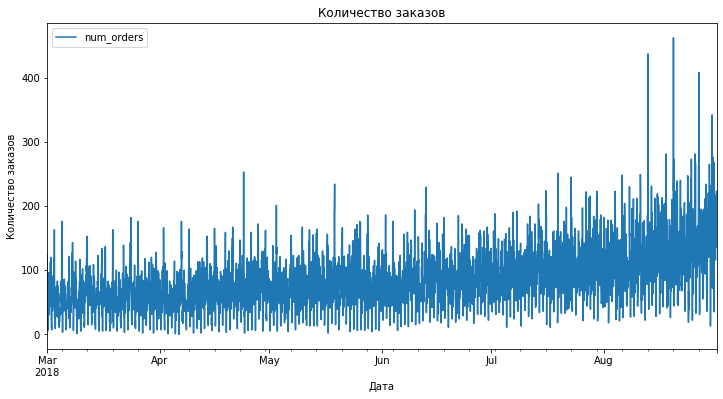

In [7]:
data.plot(figsize=(12, 6), title='Количество заказов')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

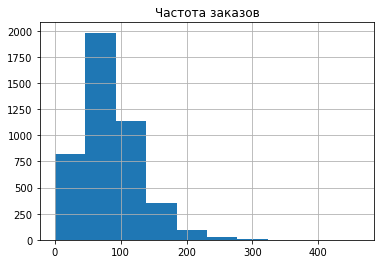

In [8]:
data.hist()
plt.title('Частота заказов')
plt.show()

In [9]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000



Видим, что количество заказов не имеет нормальное распределение, а, скорее, логнормальное. Наибольшее количество заказов происходит в августе - очевидно, это сезонные выбросы.



Проверим наш ряд на стационарность, для этого проведем тест Дикки-Фуллера на наличие единичных корней.


In [10]:
#тест Дикки-Фуллера
test_adf = sm.tsa.adfuller(data.iloc[:, 0].values)
if test_adf[0] > test_adf[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

Единичных корней нет, ряд стационарен



Ряд стационарен, теперь посмотрим на тренд распределения заказов.


<a id='correct1'></a>

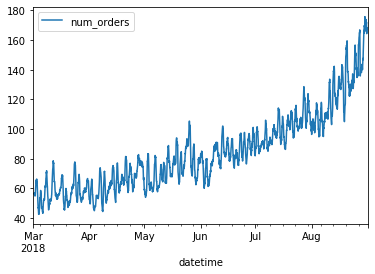

In [11]:
df = data
decomposed = seasonal_decompose(df)
decomposed.trend.plot()

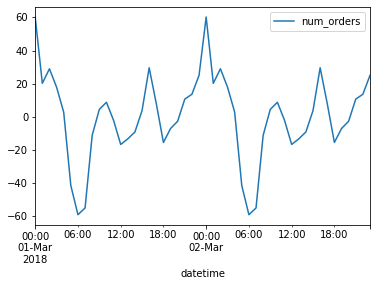

In [12]:
decomposed.seasonal[0:48].plot()

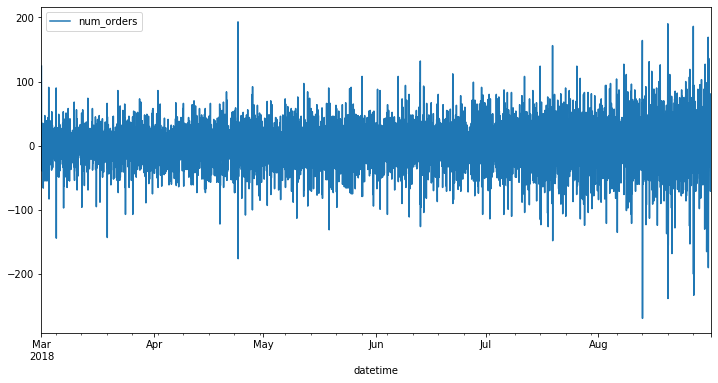

In [13]:
data = data - data.shift(fill_value=0)
data.plot(figsize=(12, 6))


Очевидно, что в летний отпускной период количество заказов резко возрастает, эти выбросы имеют сезонный характер и для построения модели будут мешать.


## Обучение


При моделировании нам необходимо разделить наш датасет на несколько выборок: обучающую, валидационную и тестовую, если только они не даны нам изначально. Для этого исходная таблица данных случайным образом разбивается на несколько с указанным нами количеством значений в каждой из них. В данном случае в качестве тестовой мы выделим 10% от общих данных, в качестве валидационной - 25% от оставшихся. Но в случае временных рядов мы не можем распределить эти выборки случайным образом, обучающая выборка должна идти с самого начала ряда и до 90%, а тестовая - последние 10%. Таким образом, последний месяц нашего ряда - август - попадет в тестовую выборку, а это недопустимо. Август - это сезонный выброс, его не получится предугадать по обучающей выборке, поэтому модель мы построим на данных, исключающих этот месяц.


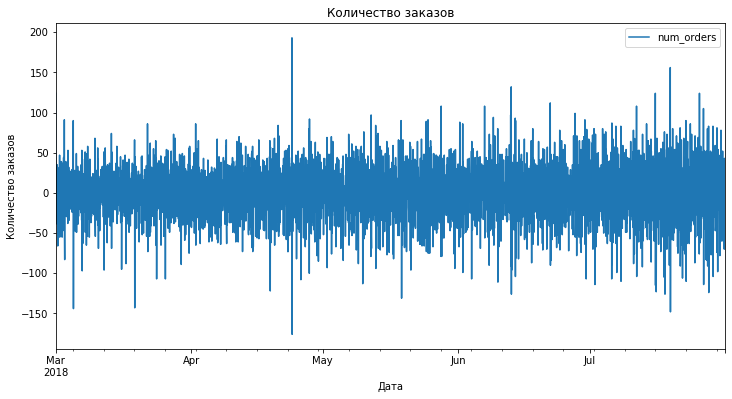

In [14]:
data = data['2018-03-01':'2018-07-31']
data.plot(figsize=(12, 6), title='Количество заказов')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()


Так ряд получился более равномерный.



Для обучения модели нам необходимо разделить исходные данные на целевой признак и обучающие признаки. Целевой признак - столбец с количеством заказов. Признаки, на которых будет обучаться модель, мы создадим сами.

В качестве таких признаков мы создадим столбец с текущими значениями часа, дня, месяца, дня недели в числовом виде, сдвиги в данных наблюдений и скользящее среднее по количеству заказов.


In [15]:
#функция добавления признаков
def make_features(data, max_lag, rolling_mean_size):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag, fill_value=0)
    data['rolling_mean'] = data['num_orders'].shift(fill_value=0).rolling(rolling_mean_size).mean()
    return data

In [16]:
make_features(data, 2, 24)
data.loc[data['rolling_mean'].isna(), 'rolling_mean'] = 0
data.head()

,num_orders,day_of_week,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,0,0,0.0
2018-03-01 01:00:00,-39,3,1,124,0,0.0
2018-03-01 02:00:00,-14,3,2,-39,124,0.0
2018-03-01 03:00:00,-5,3,3,-14,-39,0.0
2018-03-01 04:00:00,-23,3,4,-5,-14,0.0



Теперь мы готовы разделить данные по признакам и по выборкам.


In [17]:
#выделяем признаки
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']
#разбиваем значения на тренировочную, валидационную и тестовую выборки
features_data, features_test, target_data, target_test = (
    train_test_split(features, target, shuffle=False, test_size=0.1)
)
features_train, features_valid, target_train, target_valid = (
    train_test_split(features_data, target_data, shuffle=False, test_size=0.25)
)


Обучим данные с пощью трех видов моделей:

* линейная регрессия

* дерево решений

* случайный лес



Модель, дающую лучшее предсказание, мы проверим на тестовой выборке. В качестве метрики будем использовать значение RMSE.



### Линейная регрессия


In [18]:
#обучаем модель линейной регрессии
model_linear = LinearRegression()
model_linear.fit(features_train, target_train)
pred_valid = model_linear.predict(features_valid)
rmse_linear = (mean_squared_error(target_valid, pred_valid))**0.5
print('RMSE линейной регрессии:', rmse_linear)

RMSE линейной регрессии: 34.11762284527191



### Дерево решений



В моделях дерева решений и случайного леса нам понадобится разделение данных на обучающую и валидационную выборки. На обучающей мы будем обучать модель, а на валидационной подберем гиперпараметры.


In [19]:
#зададим переменные, в которые сохраним наилучшие результаты
best_depth_tree = 0
best_result_tree = 10000
best_model_tree = None
#в цикле перебираем значения глубины дерева
for depth in range(1, 11):
    #зададим модель с текущей глубиной
    model = DecisionTreeRegressor(random_state=0, max_depth=depth)
    #обучаем модель на обучающей выборке
    model.fit(features_train, target_train)
    #предсказываем результаты на валидационной выборке
    predictions = model.predict(features_valid)
    #рассчитываем RMSE
    result = (mean_squared_error(target_valid, predictions))**0.5
    #выбираем наилучший результат
    if result < best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth_tree = depth
print('Лучший RMSE модели дерева решений:', best_result_tree)

Лучший RMSE модели дерева решений: 30.286081077246493



### Случайный лес


In [20]:
#зададим переменные, в которые сохраним наилучшие результаты
best_depth_forest = 0
best_est_forest = 0
best_result_forest = 10000
best_model_forest = None
#в цикле перебираем значения глубины дерева и количества деревьев
for est in range(10, 51, 5):
    for depth in range(1, 11):
        #зададим модель
        model = RandomForestRegressor(random_state=0, n_estimators=est, max_depth=depth)
        #обучаем модель на обучающей выборке
        model.fit(features_train, target_train)
        #предсказываем результаты на валидационной выборке
        predictions = model.predict(features_valid)
        #рассчитываем RMSE
        result = (mean_squared_error(target_valid, predictions))**0.5
        #выбираем наилучший результат
        if result < best_result_forest:
            best_model_forest = model
            best_result_forest = result
            best_depth_forest = depth
            best_est_forest = est
print('Лучший RMSE модели случайного леса:', best_result_forest)

Лучший RMSE модели случайного леса: 28.006327597324947



Наилучший результат показала модель случайного леса, проверим ее на тестовой выборке.


## Тестирование


Предскажем количество заказов такси на тестовой выборке. Наилучшая модель сохранена как <i> best_model_forest </i>.


In [21]:
pred_test = best_model_forest.predict(features_test)
rmse_forest = (mean_squared_error(target_test, pred_test))**0.5
print('RMSE дерева:', rmse_forest)

RMSE дерева: 34.659678368824544


In [22]:
pred = pd.DataFrame(pred_test, index=target_test.index, columns=['pred_test'])
targ = pd.DataFrame(target_test, index=target_test.index, columns=['num_orders'])

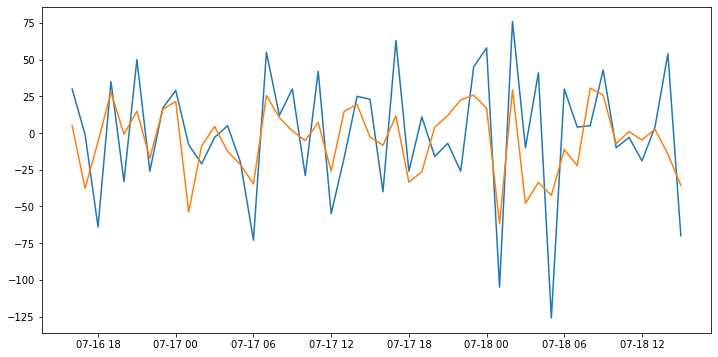

In [23]:
f, ax = plt.subplots(figsize=(12,6))
plt.plot(targ[0:48])
plt.plot(pred[0:48])
plt.show()


На тестовой выборке мы получили результат чуть хуже, но он все равно подходит по условию задачи.



В данной работе мы проанализировали исторические данные по заказу такси из аэропорта. Для прогноза количества заказов было построено три модели: модель логистической регрессии, дерева решений и случайного леса. Наилучшие результаты прогноза показала модель случайного леса с глубиной дерева 10 и количеством деревьев 25. Данная модель была проверена на тестовой выборке и также показала удовлетворительный результат. Таким образом, рекомендуем использовать ее для прогноза количества заказов в дальнейший час.
